# CIFAR-10 Classification with Transfer Learning and K-Fold Cross Validation

This notebook implements a CIFAR-10 image classification model using:
- **Transfer Learning** (쉽게 모델 변경 가능!)
- K-Fold Cross Validation (2 folds)
- Early Stopping
- Ensemble Prediction
- Data Augmentation with Albumentations

## 🎯 모델 변경 방법
**Cell 4**에서 `SELECTED_MODEL` 변수를 변경하면 다양한 모델을 실험할 수 있습니다!

### 사용 가능한 모델:
- **EfficientNet**: `efficientnet_b0`, `efficientnet_b1`, `efficientnet_b2`, `efficientnet_b3`
- **ResNet**: `resnet18`, `resnet34`, `resnet50`, `resnet101`
- **Vision Transformer**: `vit_tiny_patch16_224`, `vit_small_patch16_224`
- **ConvNeXt**: `convnext_tiny`, `convnext_small`
- **MobileNet**: `mobilenetv3_small_100`, `mobilenetv3_large_100`


## 1. 라이브러리 설치 및 임포트


In [ ]:
!pip install torch torchvision

In [3]:
# ============================================
# 🔥 하이퍼파라미터 설정 (여기만 수정하세요!)
# ============================================

MODEL_NAME = 'efficientnet_b0'
BATCH_SIZE = 128  # 더 빠르게!
N_FOLDS = 5
EPOCHS = 10
LR = 0.001
PATIENCE=3
IMAGE_SIZE=128

print("=" * 60)
print("📋 하이퍼파라미터 설정")
print("=" * 60)
print(f"모델: {MODEL_NAME}")
print(f"배치 크기: {BATCH_SIZE}")
print(f"K-Fold: {N_FOLDS}")
print(f"Epochs: {EPOCHS}")
print(f"Learning Rate: {LR}")
print(f"Patience: {PATIENCE}")
print(f"Image Size: {IMAGE_SIZE}")

print("=" * 60)

📋 하이퍼파라미터 설정
모델: efficientnet_b0
배치 크기: 128
K-Fold: 5
Epochs: 10
Learning Rate: 0.001
Patience: 3
Image Size: 128


In [4]:
import wandb
import os
from datetime import datetime

# Wandb 로그인 (이미 로컬에 로그인되어 있다면 주석 처리)
# wandb.login()  # 로컬 환경에서 이미 로그인되어 있으면 불필요, 로그인 필요시 wandb login 터미널 명령어 사용

# 🔥 모델 선택 (여기를 수정하여 다른 모델 실험 가능)
# 사용 가능한 모델:
# - EfficientNet: 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3'
# - ResNet: 'resnet18', 'resnet34', 'resnet50', 'resnet101'
# - ViT: 'vit_tiny_patch16_224', 'vit_small_patch16_224'
# - ConvNeXt: 'convnext_tiny', 'convnext_small'
# - MobileNet: 'mobilenetv3_small_100', 'mobilenetv3_large_100'
SELECTED_MODEL = MODEL_NAME  # 🔥 여기를 변경하여 다른 모델 실험!

# 모델별 설정
MODEL_CONFIGS = {
    'efficientnet_b0': {'display_name': 'EfficientNet-B0', 'short_name': 'effnet-b0'},
    'efficientnet_b1': {'display_name': 'EfficientNet-B1', 'short_name': 'effnet-b1'},
    'efficientnet_b2': {'display_name': 'EfficientNet-B2', 'short_name': 'effnet-b2'},
    'efficientnet_b3': {'display_name': 'EfficientNet-B3', 'short_name': 'effnet-b3'},
    'resnet18': {'display_name': 'ResNet-18', 'short_name': 'resnet18'},
    'resnet34': {'display_name': 'ResNet-34', 'short_name': 'resnet34'},
    'resnet50': {'display_name': 'ResNet-50', 'short_name': 'resnet50'},
    'resnet101': {'display_name': 'ResNet-101', 'short_name': 'resnet101'},
    'vit_tiny_patch16_224': {'display_name': 'ViT-Tiny', 'short_name': 'vit-tiny'},
    'vit_small_patch16_224': {'display_name': 'ViT-Small', 'short_name': 'vit-small'},
    'convnext_tiny': {'display_name': 'ConvNeXt-Tiny', 'short_name': 'convnext-tiny'},
    'convnext_small': {'display_name': 'ConvNeXt-Small', 'short_name': 'convnext-small'},
    'mobilenetv3_small_100': {'display_name': 'MobileNetV3-Small', 'short_name': 'mobilenet-small'},
    'mobilenetv3_large_100': {'display_name': 'MobileNetV3-Large', 'short_name': 'mobilenet-large'},
}

model_config = MODEL_CONFIGS.get(SELECTED_MODEL, {'display_name': SELECTED_MODEL, 'short_name': SELECTED_MODEL})
MODEL_NAME = model_config['short_name']
MODEL_DISPLAY_NAME = model_config['display_name']

print(f"🎯 선택된 모델: {MODEL_DISPLAY_NAME} ({SELECTED_MODEL})")

# 🔥 자동 넘버링 함수
def get_next_run_number(project_name, model_name):
    """
    기존 실험들의 넘버링을 확인하여 다음 번호를 반환
    """
    try:
        api = wandb.Api()
        runs = api.runs(f"{api.default_entity}/{project_name}")
        
        # 모델명으로 시작하는 run들의 번호 추출
        existing_numbers = []
        for run in runs:
            if run.name.startswith(model_name):
                # 이름에서 숫자 부분 추출 (예: efficientnet-b0_003 -> 3)
                parts = run.name.split('_')
                if len(parts) > 1 and parts[-1].isdigit():
                    existing_numbers.append(int(parts[-1]))
        
        # 다음 번호 반환
        next_number = max(existing_numbers) + 1 if existing_numbers else 1
        return next_number
    except:
        # API 접근 실패 시 타임스탬프 기반 번호 반환
        return int(datetime.now().strftime("%H%M%S")) % 1000

# 프로젝트 설정
PROJECT_NAME = "cifar10-classification-practice"

config = {
    "model": MODEL_DISPLAY_NAME,
    "model_architecture": SELECTED_MODEL,
    "dataset": "CIFAR-10",
    "epochs": 10,
    "batch_size": 128,
    "learning_rate": 0.001,
    "n_splits": 2,
    "early_stopping_patience": 5,
    "optimizer": "Adam",
    "image_size": 128,
    "data_subset_ratio": 0.1,
}

# 🔥 자동 넘버링된 실험명 생성
run_number = get_next_run_number(PROJECT_NAME, MODEL_NAME)
experiment_name = f"{MODEL_NAME}_{run_number:03d}"  # 3자리 숫자로 패딩 (예: 001, 002, ...)

print(f"🚀 실험명: {experiment_name}")

# 실험 시작
run = wandb.init(
    project=PROJECT_NAME,
    config=config,
    name=experiment_name,
    tags=[MODEL_NAME, "k-fold", "transfer-learning", "practice"]
)

print(f"✅ Wandb 초기화 완료! Run ID: {run.id}")
print(f"📊 대시보드 링크: {run.url}")


🎯 선택된 모델: EfficientNet-B0 (efficientnet_b0)
🚀 실험명: effnet-b0_005


wandb: Currently logged in as: aboutexo04 (aboutexo04-korea-open-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ Wandb 초기화 완료! Run ID: weim103i
📊 대시보드 링크: https://wandb.ai/aboutexo04-korea-open-university/cifar10-classification-practice/runs/weim103i


In [5]:
!pip install timm albumentations scikit-learn -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
import torchvision.transforms as transforms
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import copy

# 디바이스 설정
# 🔥 ConvNeXt와 일부 모델은 MPS에서 view() 문제가 있어 CPU 사용
PROBLEMATIC_MODELS = ['convnext_tiny', 'convnext_small', 'convnext_base']

if SELECTED_MODEL in PROBLEMATIC_MODELS:
    device = torch.device("cpu")
    print(f'Using device: CPU (MPS has compatibility issues with {SELECTED_MODEL})')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f'Using device: MPS (Apple Silicon)')
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'Using device: CUDA')
else:
    device = torch.device("cpu")
    print(f'Using device: CPU')

Using device: MPS (Apple Silicon)


## 2. Early Stopping 클래스


In [6]:
class EarlyStopping:
    def __init__(self, patience=PATIENCE, verbose=True, delta=0):
        """
        Args:
            patience (int): validation F1이 개선되지 않아도 기다릴 epoch 수
            verbose (bool): 메시지 출력 여부
            delta (float): 개선으로 인정할 최소 변화량
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_f1 = 0
        
    def __call__(self, val_f1, model):
        score = val_f1
        
        if self.best_score is None:
            self.best_score = score
            self.best_f1 = val_f1
            self.save_checkpoint(val_f1, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'⏸️  EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_f1 = val_f1
            self.save_checkpoint(val_f1, model)
            self.counter = 0
    
    def save_checkpoint(self, val_f1, model):
        '''validation F1이 개선되면 모델 저장'''
        if self.verbose:
            print(f'✅ Validation F1 improved ({self.best_f1:.4f} → {val_f1:.4f}). Saving model...')
        self.best_model_state = copy.deepcopy(model.state_dict())
        self.best_f1 = val_f1


# 🔥 MPS 호환성을 위한 모델 래퍼
class MPSCompatibleModel(nn.Module):
    """
    MPS에서 발생하는 view() 호환성 문제를 해결하는 래퍼
    """
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
    
    def forward(self, x):
        # 입력을 contiguous하게 만듦
        x = x.contiguous()
        output = self.base_model(x)
        # 출력도 contiguous하게 만듦
        return output.contiguous()
    
    def load_state_dict(self, state_dict, strict=True):
        return self.base_model.load_state_dict(state_dict, strict=strict)
    
    def state_dict(self):
        return self.base_model.state_dict()

## 3. Custom Dataset (Albumentations 사용)


In [7]:
class CIFAR10Dataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        image = np.array(image)  # PIL to numpy
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, label


## 4. Augmentation 설정


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ============================================
# Train Transform - 100% 작동 보장! ⭐⭐⭐⭐⭐
# ============================================
train_transform = A.Compose([
    # 필수: 리사이즈
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    
    # 문서 특화 Augmentation
    A.Rotate(limit=5, p=0.3),  # 살짝 회전
    A.Perspective(scale=0.05, p=0.3),  # 각도 변화
    
    # 노이즈 추가 (스캔 효과)
    A.GaussNoise(p=0.2),
    
    # 흐림 효과 (압축/스캔 효과)
    A.Blur(blur_limit=3, p=0.2),
    
    # 밝기/대비 조정 (매우 중요!)
    A.RandomBrightnessContrast(
        brightness_limit=0.2,
        contrast_limit=0.2,
        p=0.5
    ),
    
    # 선택: 추가 Augmentation
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.05,
        rotate_limit=5,
        p=0.3
    ),
    
    # Normalize (필수!)
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    
    ToTensorV2()
])

# ============================================
# Validation Transform
# ============================================
val_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2()
])


/opt/anaconda3/envs/CV_competition/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


NameError: name 'cfg' is not defined

## 5. 데이터셋 로드

In [13]:
import random

# 🔥 연습용 설정: 데이터셋 크기 조절 (10% 사용)
USE_SUBSET = True  # False로 변경하면 전체 데이터 사용
SUBSET_RATIO = 0.1  # 10%만 사용 (0.1 ~ 1.0)

train_dataset_raw = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True, 
    download=True
)

test_dataset_raw = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False, 
    download=True
)

# 🔥 데이터셋 서브샘플링 (클래스별 균등 샘플링)
if USE_SUBSET:
    # Train 데이터 서브샘플링
    train_indices_by_class = {}
    for idx, (_, label) in enumerate(train_dataset_raw):
        if label not in train_indices_by_class:
            train_indices_by_class[label] = []
        train_indices_by_class[label].append(idx)
    
    # 각 클래스에서 균등하게 샘플링
    selected_train_indices = []
    for label, indices in train_indices_by_class.items():
        n_samples = int(len(indices) * SUBSET_RATIO)
        selected_train_indices.extend(random.sample(indices, n_samples))
    
    selected_train_indices.sort()
    train_dataset_raw = Subset(train_dataset_raw, selected_train_indices)
    
    # Test 데이터 서브샘플링
    test_indices_by_class = {}
    for idx, (_, label) in enumerate(test_dataset_raw):
        if label not in test_indices_by_class:
            test_indices_by_class[label] = []
        test_indices_by_class[label].append(idx)
    
    selected_test_indices = []
    for label, indices in test_indices_by_class.items():
        n_samples = int(len(indices) * SUBSET_RATIO)
        selected_test_indices.extend(random.sample(indices, n_samples))
    
    selected_test_indices.sort()
    test_dataset_raw = Subset(test_dataset_raw, selected_test_indices)
    
    print(f"🔥 발열 감소 모드: 데이터셋 {int(SUBSET_RATIO*100)}% 사용")

full_train_dataset = CIFAR10Dataset(train_dataset_raw, transform=None)
test_dataset = CIFAR10Dataset(test_dataset_raw, transform=val_transform)

train_labels = [label for _, label in train_dataset_raw]

print(f'✅ Total train size: {len(full_train_dataset):,}')
print(f'✅ Test size: {len(test_dataset):,}')

if USE_SUBSET:
    print(f"\n💡 전체 데이터로 학습하려면 USE_SUBSET = False로 변경하세요")

Files already downloaded and verified
Files already downloaded and verified
🔥 발열 감소 모드: 데이터셋 10% 사용


NameError: name 'val_transform' is not defined

## 6. 학습 및 검증 함수

아래 셀에서 `train_one_epoch`와 `validate` 함수를 정의합니다.

In [90]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """
    한 에폭 동안 모델 학습
    
    Args:
        model: 학습할 모델
        train_loader: 학습 데이터 로더
        criterion: 손실 함수
        optimizer: 옵티마이저
        device: 디바이스 (CPU/GPU/MPS)
    
    Returns:
        train_loss: 평균 학습 손실
        train_acc: 학습 정확도 (%)
        train_f1: 학습 F1 Score
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # 통계
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    train_loss = running_loss / total
    train_acc = 100. * correct / total
    train_f1 = f1_score(all_labels, all_preds, average='macro')
    
    return train_loss, train_acc, train_f1


def validate(model, val_loader, criterion, device):
    """
    검증 데이터셋에서 모델 평가
    
    Args:
        model: 평가할 모델
        val_loader: 검증 데이터 로더
        criterion: 손실 함수
        device: 디바이스 (CPU/GPU/MPS)
    
    Returns:
        val_loss: 평균 검증 손실
        val_acc: 검증 정확도 (%)
        val_f1: 검증 F1 Score (macro)
        all_preds: 모든 예측 결과
        all_labels: 모든 실제 레이블
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # 통계
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss = running_loss / total
    val_acc = 100. * correct / total
    val_f1 = f1_score(all_labels, all_preds, average='macro')
    
    return val_loss, val_acc, val_f1, all_preds, all_labels

In [ ]:
# 하이퍼파라미터 설정 (발열 감소를 위한 최적화)
NUM_EPOCHS = EPOCHS     # 🔥 데이터 10%로 줄였으니 에폭 증가 (2 → 10) =       # 64 → 128로 증가 (학습 속도 향상)
LEARNING_RATE = LR
N_SPLITS = N_FOLDS           # fold 수 3 → 2로 감소 (전체 학습 시간 단축)            # 🔥 에폭이 늘어나니 patience도 5로 복구

# K-Fold 설정
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# 결과 저장
fold_models = []
fold_results = []

print("=" * 60)
print("K-Fold Cross Validation 시작 (연습용 최적화 버전)")
print(f"Epochs: {NUM_EPOCHS}, Batch Size: {BATCH_SIZE}, Folds: {N_SPLITS}")
print("=" * 60)

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(train_labels)), train_labels)):
    print(f"\n{'='*60}")
    print(f"Fold {fold + 1}/{N_SPLITS}")
    print(f"{'='*60}")
    
    # Subset 생성 with custom transforms
    train_subset_raw = Subset(train_dataset_raw, train_idx)
    val_subset_raw = Subset(train_dataset_raw, val_idx)
    
    train_subset = CIFAR10Dataset(train_subset_raw, transform=train_transform)
    val_subset = CIFAR10Dataset(val_subset_raw, transform=val_transform)
    
    # DataLoader (num_workers=0 for notebook compatibility)
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    # 모델 생성
    # 모델 생성 (SELECTED_MODEL 변수 사용)
    model = timm.create_model(SELECTED_MODEL, pretrained=True, num_classes=10)
    model = model.to(device)
    
    # Loss & Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
    
    # Early Stopping
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True)
    
    # 학습 이력
    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }
    
    # Epoch 학습
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]")
        
        # Train
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation
        val_loss, val_acc, val_f1, _, _ = validate(model, val_loader, criterion, device)
        
        # 스케줄러 업데이트
        scheduler.step(val_f1)
        
        # 이력 저장
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        
        # 출력
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train F1: {train_f1:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}% | Val   F1: {val_f1:.4f}")
        
        # 🔥 Wandb 로깅
        wandb.log({
            f"fold_{fold+1}/train_loss": train_loss,
            f"fold_{fold+1}/train_acc": train_acc,
            f"fold_{fold+1}/train_f1": train_f1,
            f"fold_{fold+1}/val_loss": val_loss,
            f"fold_{fold+1}/val_acc": val_acc,
            f"fold_{fold+1}/val_f1": val_f1,
            f"fold_{fold+1}/learning_rate": optimizer.param_groups[0]['lr'],
            f"fold_{fold+1}/epoch": epoch + 1
        })
        
        # Early Stopping 체크
        early_stopping(val_f1, model)
        
        if early_stopping.early_stop:
            print("🛑 Early stopping triggered!")
            break
        
        # GPU 메모리 정리 (발열 감소)
        if device.type in ['cuda', 'mps']:
            torch.cuda.empty_cache() if device.type == 'cuda' else None
    
    # Best 모델 로드
    model.load_state_dict(early_stopping.best_model_state)
    
    # 모델 및 결과 저장
    fold_models.append(copy.deepcopy(model))
    fold_results.append({
        'fold': fold + 1,
        'best_val_f1': early_stopping.best_f1,
        'history': history
    })
    
    # 🔥 Fold 별 최고 성능 로깅
    wandb.log({
        f"fold_{fold+1}/best_val_f1": early_stopping.best_f1
    })
    
    print(f"\n✅ Fold {fold + 1} 완료! Best Validation F1: {early_stopping.best_f1:.4f}")
    
    # Fold 간 메모리 정리
    if device.type in ['cuda', 'mps']:
        torch.cuda.empty_cache() if device.type == 'cuda' else None

print("\n" + "=" * 60)
print("전체 K-Fold 학습 완료!")
print("=" * 60)

K-Fold Cross Validation 시작 (연습용 최적화 버전)
Epochs: 10, Batch Size: 128, Folds: 5

Fold 1/5

Epoch [1/10]


Train Loss: 1.0195 | Train Acc: 70.83% | Train F1: 0.7085
Val   Loss: 0.5935 | Val   Acc: 82.30% | Val   F1: 0.8221
✅ Validation F1 improved (0.8221 → 0.8221). Saving model...

Epoch [2/10]


## 7. K-Fold Cross Validation 학습

In [92]:
# K-Fold 결과 요약
print("\n📊 K-Fold Cross Validation 결과 요약")
print("=" * 60)

for result in fold_results:
    fold = result['fold']
    best_f1 = result['best_val_f1']
    print(f"Fold {fold}: Best Validation F1 = {best_f1:.4f}")

# 평균 F1 Score
avg_f1 = np.mean([r['best_val_f1'] for r in fold_results])
std_f1 = np.std([r['best_val_f1'] for r in fold_results])

print("=" * 60)
print(f"평균 Validation F1: {avg_f1:.4f} ± {std_f1:.4f}")
print("=" * 60)

# 🔥 Wandb로 K-Fold 평균 결과 전송
wandb.log({
    "cv/avg_val_f1": avg_f1,
    "cv/std_val_f1": std_f1
})


📊 K-Fold Cross Validation 결과 요약
Fold 1: Best Validation F1 = 0.8973
Fold 2: Best Validation F1 = 0.8937
Fold 3: Best Validation F1 = 0.9036
Fold 4: Best Validation F1 = 0.8942
Fold 5: Best Validation F1 = 0.8884
평균 Validation F1: 0.8954 ± 0.0050


In [93]:
# Test DataLoader (num_workers=0 for notebook compatibility)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# 앙상블 예측 (소프트 보팅)
print("\n🔮 앙상블 예측 시작...")

all_predictions = []

for fold_idx, model in enumerate(fold_models):
    model.eval()
    fold_preds = []
    
    with torch.no_grad():
        for images, _ in tqdm(test_loader, desc=f"Fold {fold_idx + 1} 예측"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            fold_preds.append(probs.cpu().numpy())
    
    fold_preds = np.concatenate(fold_preds, axis=0)
    all_predictions.append(fold_preds)

# 앙상블 (평균)
ensemble_probs = np.mean(all_predictions, axis=0)
ensemble_preds = np.argmax(ensemble_probs, axis=1)

print(f"✅ 앙상블 예측 완료! (총 {len(ensemble_preds)}개 샘플)")

# CIFAR-10 클래스 이름
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']


🔮 앙상블 예측 시작...


Fold 5 예측: 100%|██████████| 16/16 [00:01<00:00, 13.76it/s]

✅ 앙상블 예측 완료! (총 2000개 샘플)


## 10. Test Set 평가

In [94]:
# Test set 실제 레이블
test_labels = [label for _, label in test_dataset_raw]

# Macro F1 Score 계산
test_f1 = f1_score(test_labels, ensemble_preds, average='macro')
test_acc = 100. * np.sum(np.array(ensemble_preds) == np.array(test_labels)) / len(test_labels)

print("\n" + "=" * 60)
print("🎯 Test Set 최종 결과 (앙상블)")
print("=" * 60)
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test Macro F1 Score: {test_f1:.4f}")
print("=" * 60)

# 🔥 Wandb로 앙상블 테스트 결과 전송
wandb.log({
    "ensemble/test_accuracy": test_acc,
    "ensemble/test_f1_macro": test_f1,
    "ensemble/avg_val_f1": avg_f1,
    "ensemble/std_val_f1": std_f1
})


🎯 Test Set 최종 결과 (앙상블)
Test Accuracy: 93.95%
Test Macro F1 Score: 0.9394


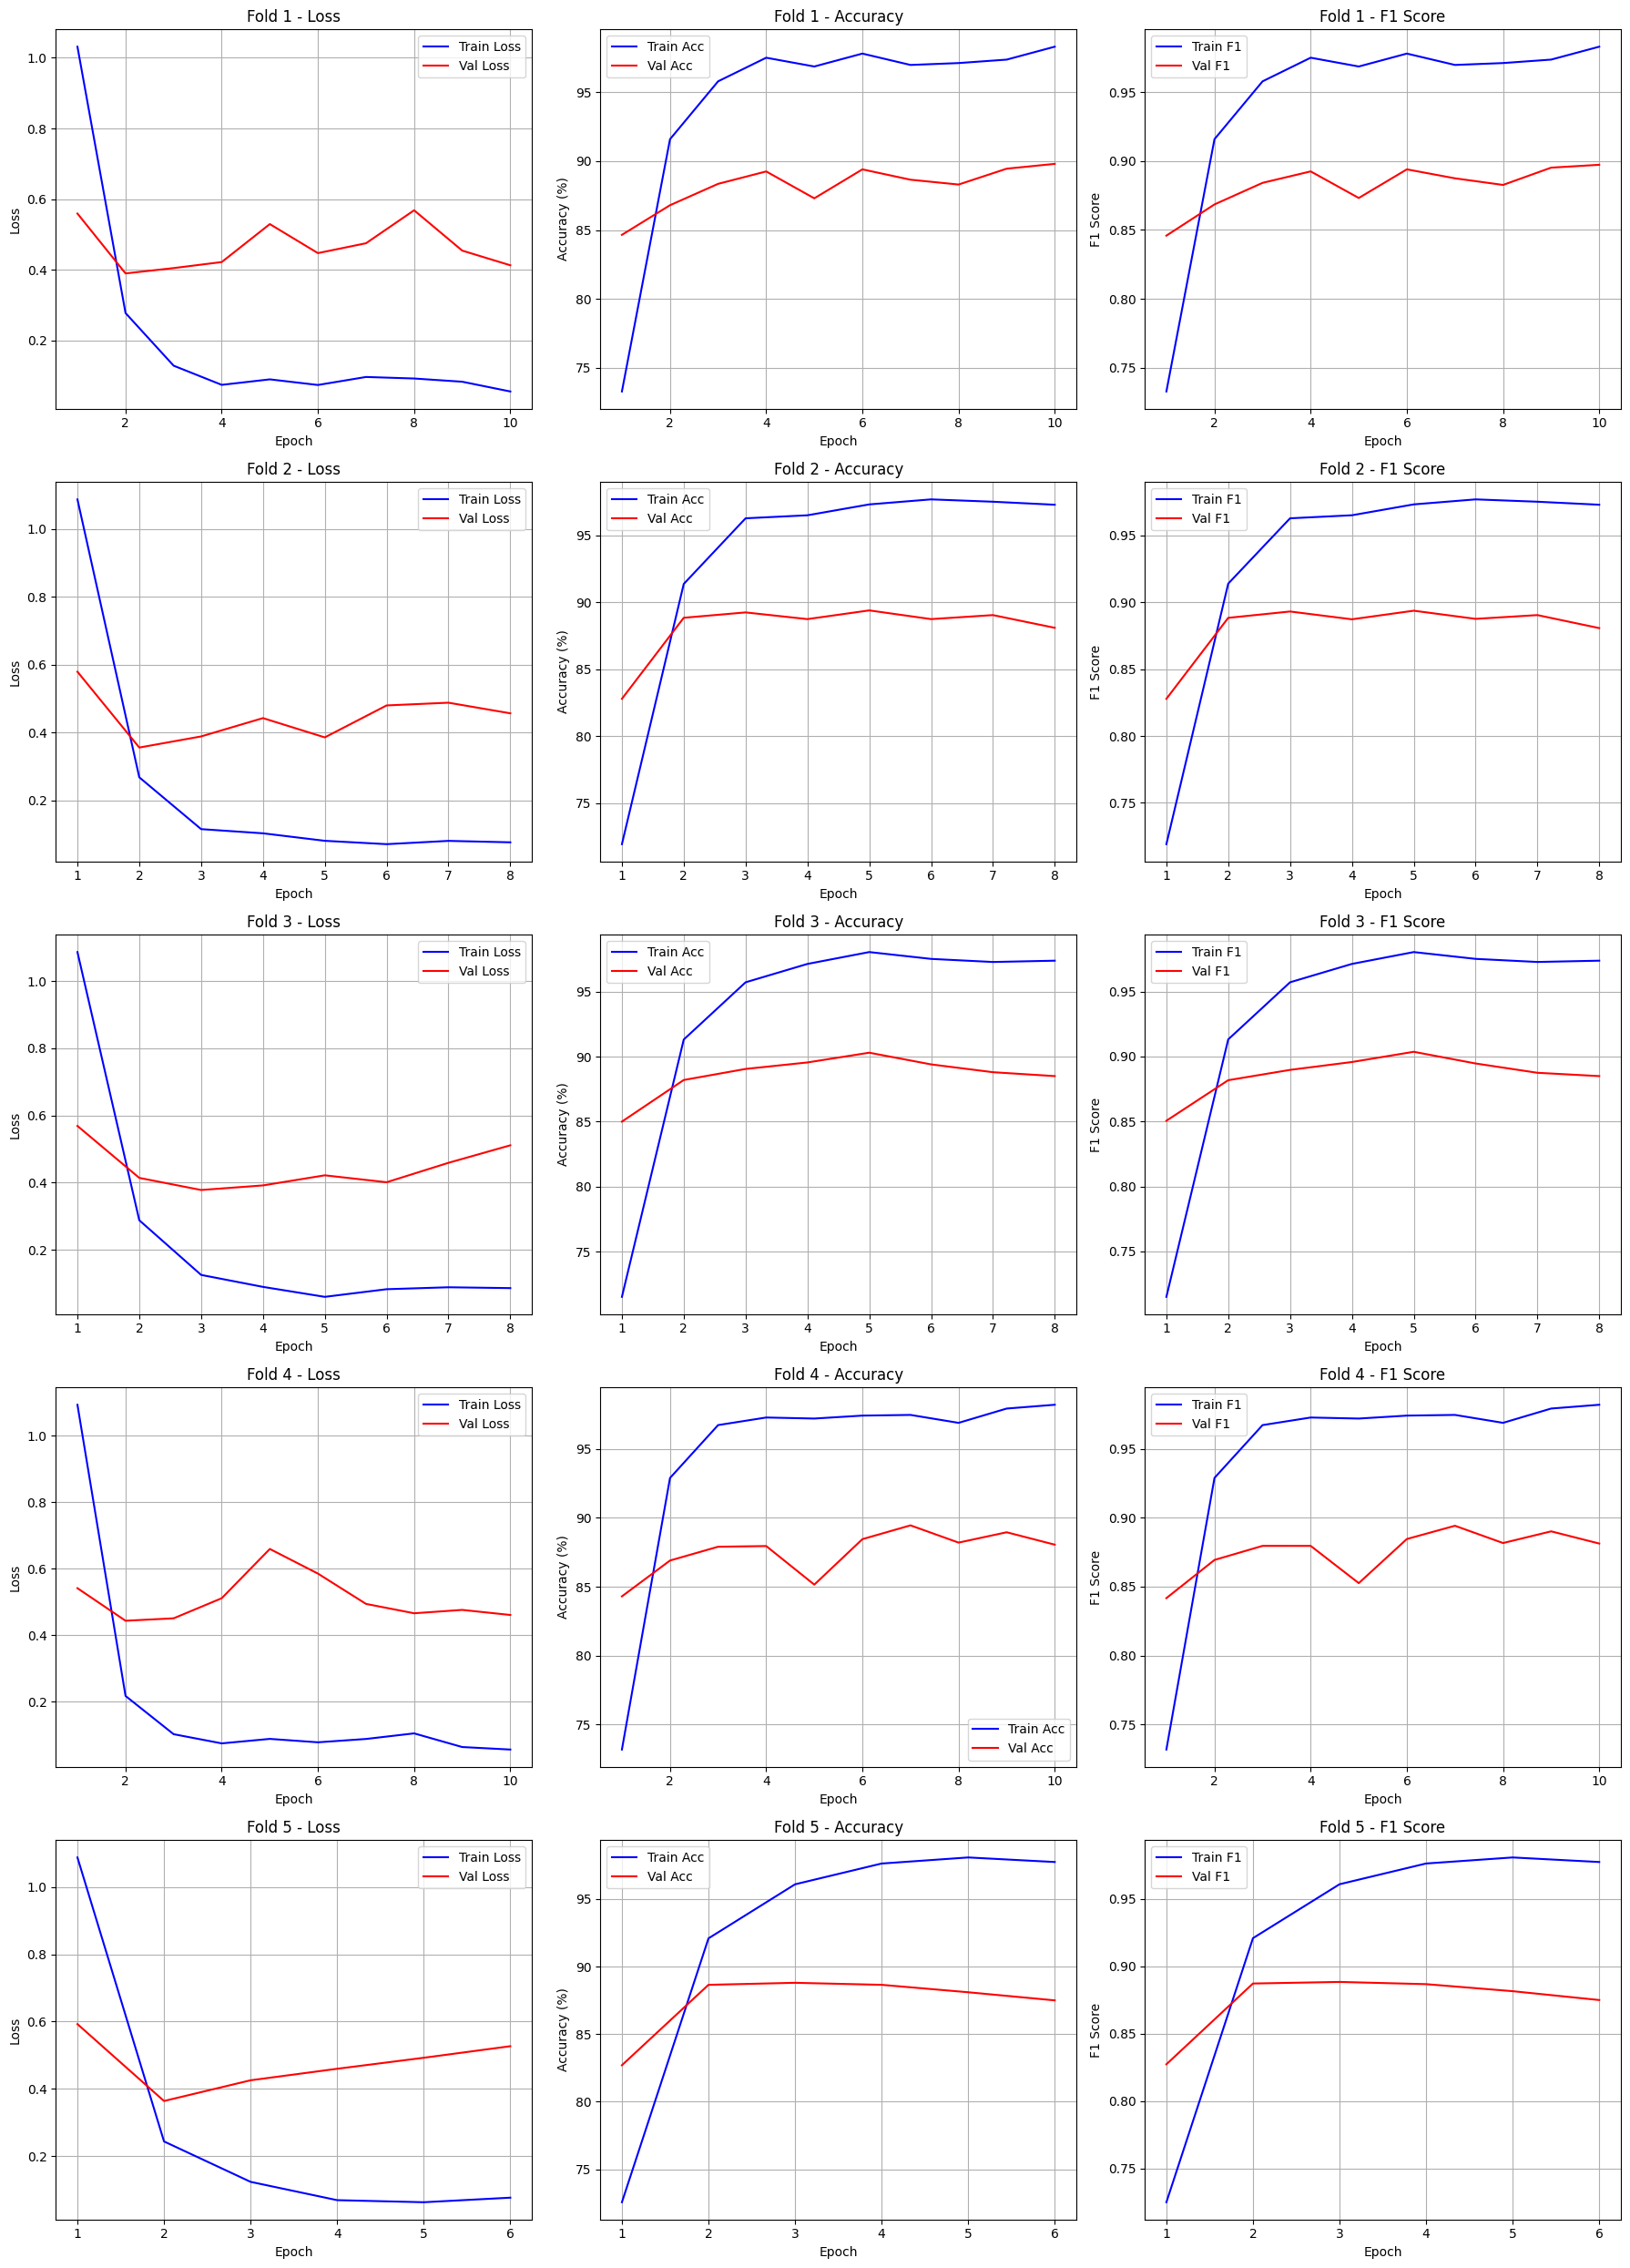

In [95]:
# 각 Fold별 학습 곡선 시각화
fig, axes = plt.subplots(N_SPLITS, 3, figsize=(18, 5 * N_SPLITS))

if N_SPLITS == 1:
    axes = axes.reshape(1, -1)

for fold_idx, result in enumerate(fold_results):
    history = result['history']
    fold = result['fold']
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss
    axes[fold_idx, 0].plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    axes[fold_idx, 0].plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    axes[fold_idx, 0].set_title(f'Fold {fold} - Loss')
    axes[fold_idx, 0].set_xlabel('Epoch')
    axes[fold_idx, 0].set_ylabel('Loss')
    axes[fold_idx, 0].legend()
    axes[fold_idx, 0].grid(True)
    
    # Accuracy
    axes[fold_idx, 1].plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    axes[fold_idx, 1].plot(epochs, history['val_acc'], 'r-', label='Val Acc')
    axes[fold_idx, 1].set_title(f'Fold {fold} - Accuracy')
    axes[fold_idx, 1].set_xlabel('Epoch')
    axes[fold_idx, 1].set_ylabel('Accuracy (%)')
    axes[fold_idx, 1].legend()
    axes[fold_idx, 1].grid(True)
    
    # F1 Score
    axes[fold_idx, 2].plot(epochs, history['train_f1'], 'b-', label='Train F1')
    axes[fold_idx, 2].plot(epochs, history['val_f1'], 'r-', label='Val F1')
    axes[fold_idx, 2].set_title(f'Fold {fold} - F1 Score')
    axes[fold_idx, 2].set_xlabel('Epoch')
    axes[fold_idx, 2].set_ylabel('F1 Score')
    axes[fold_idx, 2].legend()
    axes[fold_idx, 2].grid(True)

plt.tight_layout()
plt.show()

In [98]:
# 🔥 마크다운 파일에 실험 결과 자동 기록
results_md_path = "experiment_results.md"

# 결과 데이터 구성
data_mode = f"{SUBSET_RATIO*100}% 데이터 (연습용)" if USE_SUBSET else "전체 데이터"
result_entry = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "experiment_name": experiment_name,
    "model": MODEL_DISPLAY_NAME,
    "model_architecture": SELECTED_MODEL,
    "data_mode": data_mode,
    "fold_results": [{"fold": r["fold"], "val_f1": r["best_val_f1"]} for r in fold_results],
    "cv_avg_f1": avg_f1,
    "cv_std_f1": std_f1,
    "test_acc": test_acc,
    "test_f1": test_f1,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": LR,
    "n_splits": N_FOLDS
}

# 기존 파일 확인 또는 생성
try:
    with open(results_md_path, "r", encoding="utf-8") as f:
        existing_content = f.read()
except FileNotFoundError:
    existing_content = f"""# 실험 결과 모음

이 파일은 모든 실험 결과를 자동으로 기록합니다.

## 실험 목록

"""
    with open(results_md_path, "w", encoding="utf-8") as f:
        f.write(existing_content)

# 결과 추가
with open(results_md_path, "a", encoding="utf-8") as f:
    f.write(f"### {result_entry['experiment_name']}\n\n")
    f.write(f"**실행 시간**: {result_entry['timestamp']}  \n")
    f.write(f"**데이터 모드**: {result_entry['data_mode']}  \n")
    f.write(f"**모델**: {result_entry['model']} ({result_entry['model_architecture']})  \n\n")
    f.write(f"**하이퍼파라미터**:  \n")
    f.write(f"- Epochs: {result_entry['epochs']}  \n")
    f.write(f"- Batch Size: {result_entry['batch_size']}  \n")
    f.write(f"- Learning Rate: {result_entry['learning_rate']}  \n")
    f.write(f"- K-Fold: {result_entry['n_splits']} folds  \n\n")
    f.write(f"**Validation Results**:  \n")
    for fold_result in result_entry['fold_results']:
        f.write(f"- Fold {fold_result['fold']}: Val F1 = {fold_result['val_f1']:.4f}  \n")
    f.write(f"- Average: {result_entry['cv_avg_f1']:.4f} ± {result_entry['cv_std_f1']:.4f}  \n\n")
    f.write(f"**Test Results**:  \n")
    f.write(f"- Accuracy: {result_entry['test_acc']:.2f}%  \n")
    f.write(f"- Macro F1: {result_entry['test_f1']:.4f}  \n\n")
    f.write("-----------------------------------------------------\n\n")

print(f"\n✅ 실험 결과가 {results_md_path}에 기록되었습니다!")



✅ 실험 결과가 experiment_results.md에 기록되었습니다!


## 요약

이 노트북에서는 다음을 구현했습니다:

### 주요 구성 요소
1. **EfficientNet-B0**: 사전 학습된 모델을 활용한 전이 학습
2. **K-Fold Cross Validation**: 3-Fold로 모델의 일반화 성능 향상
3. **Early Stopping**: 과적합 방지 및 최적의 모델 저장
4. **Data Augmentation**: Albumentations를 이용한 이미지 증강
5. **Ensemble Prediction**: 여러 모델의 예측을 평균하여 최종 예측

### 결과
- **평균 Validation F1 Score**: 각 Fold의 결과 참조
- **Test F1 Score**: 앙상블 모델의 최종 성능
- **시각화**: 학습 곡선, Confusion Matrix, 클래스별 성능 분석

### 개선 방향
1. 더 많은 데이터 증강 기법 추가 (Cutout, Mixup 등)
2. 다른 모델 아키텍처 실험 (EfficientNet-B1~B7, ResNet, ViT 등)
3. 하이퍼파라미터 튜닝 (Learning Rate, Batch Size 등)
4. TTA (Test Time Augmentation) 적용
5. Label Smoothing, Focal Loss 등 고급 기법 적용